# Methods for Portfolio Optimization

In [506]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import linprog
from tabulate import tabulate

### Function

In [507]:
# Funzione per calcolare il rendimento di un portafoglio
def portfolio_return(weights, mean_returns):
    return np.dot(weights.T, mean_returns)

# Funzione per calcolare il rischio (varianza) di un portafoglio
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Funzione per minimizzare il rischio dato un livello di rendimento atteso
def minimize_risk(weights, mean_returns, cov_matrix, target_return):
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, mean_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))
    result = minimize(portfolio_risk, len(mean_returns) * [1. / len(mean_returns)], args=(cov_matrix,), 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def generate_random_array(n):
    random_nums = np.random.rand(n)
    total = np.sum(random_nums)
    random_array = random_nums / total
    return random_array

import numpy as np

def calculate_gain(initial_amount, years, weekly_mean_return):
    """
    Calculates the expected gain given an initial amount, a time period in years, and the weekly mean return.

    :param initial_amount: Initial investment amount in euros.
    :param years: Time period in years.
    :param weekly_mean_return: Weekly mean return in percentage.
    :return: Final amount after the specified time period.
    """
    weeks_per_year = 52
    total_weeks = years * weeks_per_year
    weekly_return_decimal = weekly_mean_return / 100
    
    # Calculate the final gain using the compound interest formula
    final_amount = initial_amount * (1 + weekly_return_decimal) ** total_weeks
    roi = ((final_amount - initial_amount) / initial_amount) * 100

    return final_amount, roi

def calculate_annual_return(weekly_mean_return):
    """
    Converts weekly mean return to annual return using compound interest formula.

    :param weekly_mean_return: Weekly mean return in percentage.
    :return: Annual return in percentage.
    """
    # Convert the weekly mean return from percentage to decimal
    weekly_return_decimal = weekly_mean_return / 100
    
    # Calculate the annual return using the compound interest formula
    annual_return_decimal = (1 + weekly_return_decimal) ** 52 - 1
    
    # Convert the annual return back to percentage
    annual_return_percentage = annual_return_decimal * 100
    
    return annual_return_percentage

## Dataset
https://www.francescocesarone.com/data-sets


### Ftse100

FTSE100 FOLDER

The folder contains the weekly linear returns for the Ftse100 from 01-22-2007 to 05-06-2013.
These returns are available into two extensions (.txt & .mat).

The files 'IndRet_Ftse100' contain a column vector which is the weekly linear returns of the market index values.

The files 'RR_Ftse100' contain a matrix where each column is the weekly linear returns of each asset.

NOTE: The returns are calculated from the weekly prices adjusted for dividends downloaded from yahoo.finance.com. 
Stocks with more than two consecutive missing values were disregarded, while the individual missing values were 
interpolated. 

In [538]:
PORTFOLIO = 'Ftse100'

mat_file_1 = 'Ftse100/IndRet_Ftse100.mat'
mat_file_2 = 'Ftse100/RR_Ftse100.mat'

mat_data_1 = scipy.io.loadmat(mat_file_1)
mat_data_2 = scipy.io.loadmat(mat_file_2)
#print(mat_data_2.keys())

array_ret = mat_data_1['Ret_ftse100'].flatten()
matrix_ret = mat_data_1['Ret_ftse100']
matrix_rr = mat_data_2['RR']

# Calcola i rendimenti medi e la matrice di covarianza
mean_returns = np.mean(matrix_rr, axis=0)
cov_matrix = np.cov(matrix_rr, rowvar=False)

nStocks = len(matrix_rr.T)
print(nStocks)

63


### Stoxx50

EUROSTOXX50 FOLDER

The folder contains the weekly linear returns for the Eurostoxx50 from 01-22-2007 to 05-06-2013.
These returns are available into two extensions (.txt & .mat).

The files 'IndRet_Stoxx50' contain a column vector which is the weekly linear returns of the market index values.

The files 'RR_Stoxx50' contain a matrix where each column is the weekly linear returns of each asset.

NOTE: The returns are calculated from the weekly prices adjusted for dividends downloaded from yahoo.finance.com. 
Stocks with more than two consecutive missing values were disregarded, while the individual missing values were 
interpolated. 

In [509]:
PORTFOLIO = 'EuroStoxx50'

mat_file_1 = 'EuroStoxx50/IndRet_Stoxx50.mat'
mat_file_2 = 'EuroStoxx50/RR_Stoxx50.mat'

mat_data_1 = scipy.io.loadmat(mat_file_1)
mat_data_2 = scipy.io.loadmat(mat_file_2)
#print(mat_data_2.keys())

array_ret = mat_data_1['Ret_stoxx50'].flatten()
matrix_ret = mat_data_1['Ret_stoxx50']
matrix_rr = mat_data_2['RR']

# Calcola i rendimenti medi e la matrice di covarianza
mean_returns = np.mean(matrix_rr, axis=0)
cov_matrix = np.cov(matrix_rr, rowvar=False)

nStocks = len(matrix_rr.T)
print(nStocks)

32


### FTSE Mib

The folder contains the weekly linear returns for the FtseMib from 01-22-2007 to 05-06-2013.
These returns are available into two extensions (.txt & .mat).

The files 'IndRet_FtseMib' contain a column vector which is the weekly linear returns of the market index values.

The files 'RR_FtseMib' contain a matrix where each column is the weekly linear returns of each asset.

NOTE: The returns are calculated from the weekly prices adjusted for dividends downloaded from yahoo.finance.com. 
Stocks with more than two consecutive missing values were disregarded, while the individual missing values were 
interpolated. 

In [510]:
PORTFOLIO = 'FSTE Mib'

mat_file_1 = 'FtseMib/IndRet_FtseMib.mat'
mat_file_2 = 'FtseMib/RR_FtseMib.mat'

mat_data_1 = scipy.io.loadmat(mat_file_1)
mat_data_2 = scipy.io.loadmat(mat_file_2)
#print(mat_data_2.keys())

array_ret = mat_data_1['Ret_ftsemib'].flatten()
matrix_ret = mat_data_1['Ret_ftsemib']
matrix_rr = mat_data_2['RR']

# Calcola i rendimenti medi e la matrice di covarianza
mean_returns = np.mean(matrix_rr, axis=0)
cov_matrix = np.cov(matrix_rr, rowvar=False)

nStocks = len(matrix_rr.T)
print(nStocks)

34


## Analytics

Index Name: Ftse100
N. Stock: 63


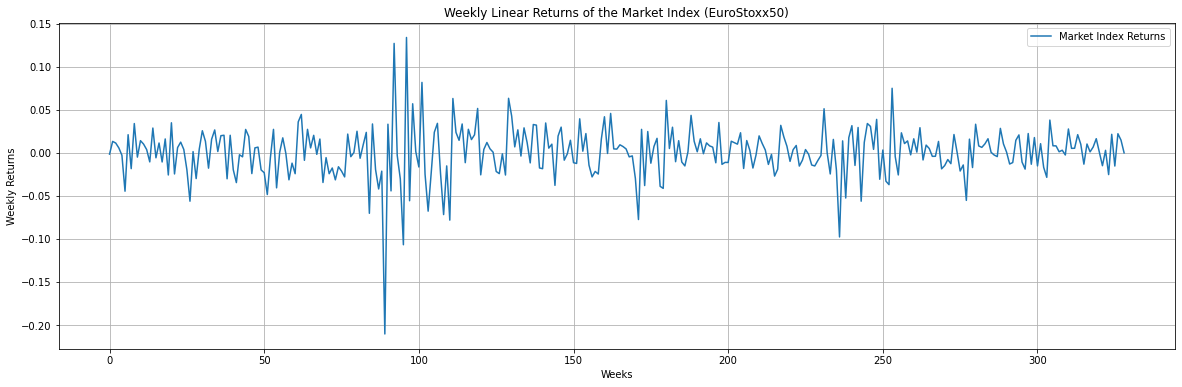

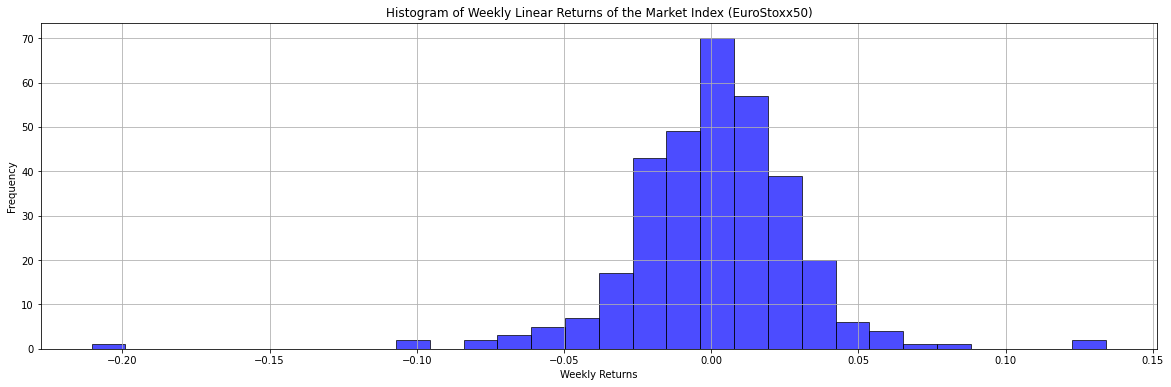

In [539]:
print(f"Index Name: {PORTFOLIO}")
print(f"N. Stock: {nStocks}")

# Grafico del rendimento settimanale dell'indice di mercato
plt.figure(figsize=(20, 6))
plt.plot(array_ret, label='Market Index Returns')
plt.xlabel('Weeks')
plt.ylabel('Weekly Returns')
plt.title('Weekly Linear Returns of the Market Index (EuroStoxx50)')
plt.legend()
plt.grid(True)
plt.show()

# Istogramma dei rendimenti settimanali del mercato
plt.figure(figsize=(20, 6))
plt.hist(array_ret, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Weekly Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Weekly Linear Returns of the Market Index (EuroStoxx50)')
plt.grid(True)
plt.show()

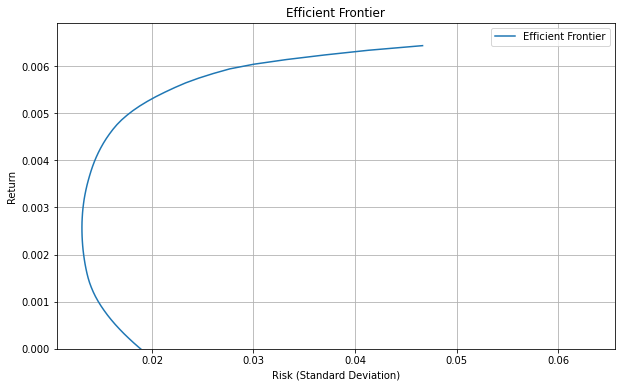

In [540]:
# Calcola la frontiera efficiente
target_returns = np.linspace(min(mean_returns), max(mean_returns), 100)
efficient_portfolios = []

for target_return in target_returns:
    efficient_portfolios.append(minimize_risk(len(mean_returns) * [1. / len(mean_returns)], mean_returns, cov_matrix, target_return))

# Estrai i rischi e i rendimenti dei portafogli efficienti
risks = [portfolio_risk(x['x'], cov_matrix) for x in efficient_portfolios]
returns = [portfolio_return(x['x'], mean_returns) for x in efficient_portfolios]

# Visualizza la frontiera efficiente
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, label='Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.ylim(0) 
plt.legend()
plt.grid(True)
plt.show()

## Portfolio Optimizations

We have $n$ avaiable assets. We call $w_i$ the quantity of money invested on the
$i$-th asset during the considered period and with $r_i$ the returns on the $i$-th
asset. We have two different constraints. The first one is non-negativity for the
variables (i.e., $w_i$ ≥ 0). It basically means that short selling (selling asset that
we still don’t own) is not allowed. We then have the budget constraint:

$
\begin{equation}
\sum_{i=1}^{n} w_i = B
\end{equation}
$

the total amount of money invested needs to be equal to the budget $B$ ($B$ can be simply set to 1).
Consider a stochastic model for the returns: $r ∈ R^n$ is a randomly generated vector with mean $\overline{r}$ and covariance $\Sigma$. Thus expected return will be:
$
\begin{equation}
\overline{r}^\intercal \, w
\end{equation}
$
and variance (risk)
$
\begin{equation}
w^\intercal \, \Sigma \, w
\end{equation}
$
Classic portfolio problem, described by Markowitz (1952), is a convex quadratic programming problem:
$
\begin{equation}
\begin{split}
\underset{w∈R^n}{min} \quad \gamma \, w^\intercal \, \Sigma \, w - \overline{r}^\intercal \, w \\
s.t. \quad e^\intercal w = 1 \\
w > 0
\end{split}
\end{equation} 
$
with $\gamma$ > 0 risk-aversion parameter. Goal is thus finding the set of assets that
minimizes the variance (risk connected to the given portfolio) while maximizing
the expected return (we obviously need to satisfy budget and non-negativity
constraints).

In [541]:
def checkMeanRet(weights, ret_mean):
    return np.dot(ret_mean.T, weights)

def checkSumOne(weights):
    return np.sum(weights) - 1

#def riskFunction(weights):
#    return np.dot(w.T, np.dot(cov, weights))

def loss(weights, ret_mean, cov, RISK_AVERSION):
    return  np.dot(RISK_AVERSION, np.dot(weights.T, np.dot(cov, weights))) -  np.dot(ret_mean.T, weights)

### Gradient

$
\begin{equation}
\nabla f(w_k) = 2 \, \gamma \, \Sigma \, w - \overline{r}^\intercal\\
\end{equation} 
$

In [542]:
def gradient(weights, ret_mean, cov, RISK_AVERSION):
    return  RISK_AVERSION * 2 * np.dot(weights, cov) -  ret_mean.T

## Frank-Wolfe and Pairwise Frank-Wolfe over the Markowitz portfolio problems

### Frank-Wolfe

In [765]:
RISK_AVERSION = 10

In [766]:
def linear_solver2(grad):
    c = grad # Use the positive gradient for minimization
    A_eq = np.ones((1, nStocks))
    b_eq = np.array([1])
    bounds = [(0, 1) for _ in range(nStocks)]
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    return res.x

def linear_solver(grad):
    """
    Linear Minimization Oracle (LMO) without using linprog.
    
    Parameters:
    - grad: The gradient at the current point.
    
    Returns:
    - The solution vector that minimizes the linear objective function.
    """
    s = np.zeros_like(grad)
    s[np.argmin(grad)] = 1  # Set the position with the smallest gradient to 1
    return s


def duality_gap(weights, grad):
    """
    Compute the duality gap for the given weights and gradient.
    """
    s = linear_solver(grad)
    return np.dot(grad, weights - s)

In [767]:
%%time

ITERATIONS = 20

weights = generate_random_array(nStocks)

loss_values_fw = []
grad_values_fw = []
returns_iteration_fw = []

for itr in range(1, ITERATIONS):
    if itr % (ITERATIONS * 0.05) == 0:
        print(f"{int(itr/ITERATIONS*100):02}%", end="")

    grad = gradient(weights, mean_returns, cov_matrix, RISK_AVERSION)
    s = linear_solver(grad)

    # Store values for plotting
    loss_values_fw.append(loss(weights, mean_returns, cov_matrix, RISK_AVERSION))
    grad_values_fw.append(np.linalg.norm(grad))
    returns_iteration_fw.append(checkMeanRet(weights, mean_returns))

    gamma = 2 / (itr + 2) 
    weights = (1 - gamma) * weights + gamma * s
    current_loss = loss(weights, mean_returns, cov_matrix, RISK_AVERSION)

    if abs(duality_gap(weights, grad)) < 1e-6: 
        print('Duality Gap Convergence itr: ', itr)
        break 

    if itr % (ITERATIONS * 0.05) == 0:
        print(f" - ret {(returns_iteration_fw[-1])*100:05.2f}% - loss {loss(weights, mean_returns, cov_matrix, RISK_AVERSION):05.6f}")

optimal_weights_fw = weights

def second_largest_partition(arr):
    return np.partition(arr, -2)[-2]

print('\n' + PORTFOLIO)
print(f"Sec Max Weights: {second_largest_partition(optimal_weights_fw)}")
print(f"Max Weights: {np.max(optimal_weights_fw)}")
print("Sum weights: ", np.sum(optimal_weights_fw))

05% - ret 00.23% - loss -0.000247
10% - ret 00.34% - loss -0.001121
15% - ret 00.41% - loss -0.001271
20% - ret 00.47% - loss -0.001460
25% - ret 00.45% - loss -0.001774
30% - ret 00.44% - loss 0.025182
35% - ret 00.44% - loss 0.014410
40% - ret 00.41% - loss 0.008311
45% - ret 00.40% - loss 0.004810
50% - ret 00.42% - loss 0.002923
55% - ret 00.42% - loss 0.001475
60% - ret 00.42% - loss 0.000533
65% - ret 00.42% - loss 0.000200
70% - ret 00.44% - loss -0.000369
75% - ret 00.44% - loss -0.000744
80% - ret 00.45% - loss -0.001053
85% - ret 00.46% - loss -0.001277
90% - ret 00.45% - loss -0.001410
95% - ret 00.44% - loss -0.001536

Ftse100
Sec Max Weights: 0.1809625528168438
Max Weights: 0.29537375892354867
Sum weights:  0.9999999999999999
CPU times: user 4.1 ms, sys: 5.16 ms, total: 9.27 ms
Wall time: 10.1 ms



Ftse100
Final weights: [9.66614807e-05 9.30980365e-05 5.24281150e-02 1.32975664e-04]
Sum of weights: 0.9999999999999999
Weekly Return Portfolio:  0.4393334696428365 %
Yearly Return Portfolio:  25.60263323553038 %
Max ret mean:  0.006432427743566206
Risk:  0.017 %


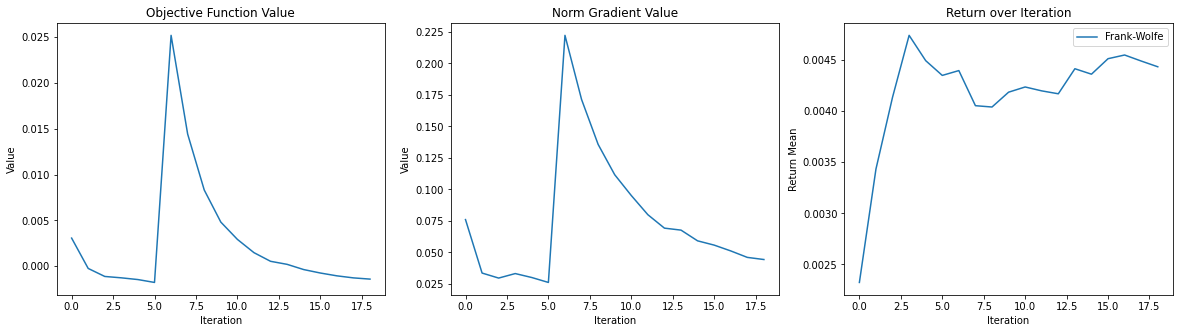

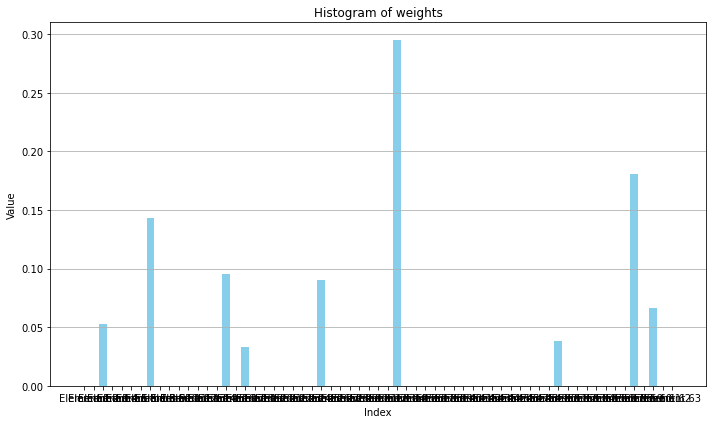

In [768]:
# Plotting the metrics
plt.figure(figsize=(20, 5))

# Loss Function Values
plt.subplot(1, 3, 1)
plt.plot(loss_values_fw)
plt.title('Objective Function Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Norm Gradient Values
plt.subplot(1, 3, 2)
plt.plot(grad_values_fw)
plt.title('Norm Gradient Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 3, 3)
plt.plot(returns_iteration_fw, label='Frank-Wolfe')
#plt.plot(solval_k5[0], label='Solution Retuns')
plt.title('Return over Iteration')
plt.xlabel('Iteration')
plt.ylabel('Return Mean')
plt.legend()

ret_mean_fw = checkMeanRet(optimal_weights_fw, mean_returns) * 100
risk_fw = portfolio_risk(optimal_weights_fw, cov_matrix)

print('\n' + PORTFOLIO)
print("Final weights:", optimal_weights_fw[:4])
print("Sum of weights:", np.sum(optimal_weights_fw))
print('Weekly Return Portfolio: ', ret_mean_fw, "%")
print('Yearly Return Portfolio: ', calculate_annual_return(ret_mean_fw), "%")
print('Max ret mean: ', np.max(mean_returns))
print("Risk: ", np.round(risk_fw,3), "%")

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(len(optimal_weights_fw)), optimal_weights_fw, color='skyblue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Histogram of weights')
plt.xticks(range(len(optimal_weights_fw)), labels=[f'Element {i+1}' for i in range(len(optimal_weights_fw))])
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

### Frank Wolfe Line Search

In [769]:
def line_search(weights, direction, ret_mean, cov_matrix, RISK_AVERSION):
    gamma_range = np.linspace(0, 1, 100)
    losses = [loss((1 - gamma) * weights + gamma * direction, ret_mean, cov_matrix, RISK_AVERSION) for gamma in gamma_range]
    optimal_gamma = gamma_range[np.argmin(losses)]
    return optimal_gamma

ITERATIONS = 20

loss_values_ls = []
grad_values_ls = []
returns_iteration_ls = []

weights = np.ones(nStocks) / nStocks

for itr in range(ITERATIONS):
    if itr % (ITERATIONS * 0.05) == 0:
        print(f"{int(itr/ITERATIONS*100):02}%", end="")

    grad = gradient(weights, mean_returns, cov_matrix, RISK_AVERSION)
    s = np.zeros(nStocks)
    s[np.argmin(grad)] = 1

    # Store values for plotting
    loss_values_ls.append(loss(weights, mean_returns, cov_matrix, RISK_AVERSION))
    grad_values_ls.append(np.linalg.norm(grad))
    returns_iteration_ls.append(checkMeanRet(weights, mean_returns))
    
    # Calcola il passo ottimale con la line search
    gamma = line_search(weights, s, mean_returns, cov_matrix, RISK_AVERSION)
    weights = (1 - gamma) * weights + gamma * s
    
    # Proiezione per assicurare che i pesi siano validi
    weights = np.clip(weights, 0, 1)
    weights /= np.sum(weights)
    
    # Verifica la convergenza
    if np.linalg.norm(grad) < 1e-6:
        break

    if itr % (ITERATIONS * 0.05) == 0:
        print(f" - ret {(returns_iteration_ls[-1])*100:05.2f}% - loss {loss(weights, mean_returns, cov_matrix, RISK_AVERSION):05.6f}")

# Esegui l'ottimizzazione
optimal_weights_ls = weights

print('\n' + PORTFOLIO)
print(f"Sec Max Weights: {second_largest_partition(optimal_weights_ls)}")
print(f"Max Weights: {np.max(optimal_weights_ls)}")
print("Sum weights: ", np.sum(optimal_weights_ls))

00% - ret 00.23% - loss -0.000286
05% - ret 00.35% - loss -0.000992
10% - ret 00.42% - loss -0.001509
15% - ret 00.44% - loss -0.001599
20% - ret 00.43% - loss -0.001719
25% - ret 00.43% - loss -0.001731
30% - ret 00.43% - loss -0.001804
35% - ret 00.43% - loss -0.001804
40% - ret 00.43% - loss -0.001804
45% - ret 00.43% - loss -0.001804
50% - ret 00.43% - loss -0.001804
55% - ret 00.43% - loss -0.001804
60% - ret 00.43% - loss -0.001804
65% - ret 00.43% - loss -0.001804
70% - ret 00.43% - loss -0.001804
75% - ret 00.43% - loss -0.001804
80% - ret 00.43% - loss -0.001804
85% - ret 00.43% - loss -0.001804
90% - ret 00.43% - loss -0.001804
95% - ret 00.43% - loss -0.001804

Ftse100
Sec Max Weights: 0.2016875472381281
Max Weights: 0.3507610493354673
Sum weights:  1.0



Ftse100
Final weights: [0.00143143 0.00143143 0.00143143 0.00143143]
Sum of weights: 1.0
Weekly Return Portfolio:  0.4259536645928351 %
Yearly Return Portfolio:  24.735524512824103 %
Max ret mean:  0.006432427743566206
Risk:  0.016 %


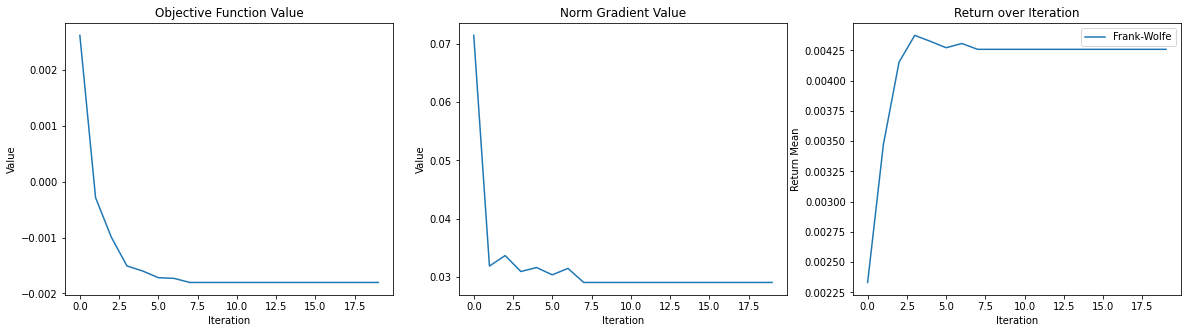

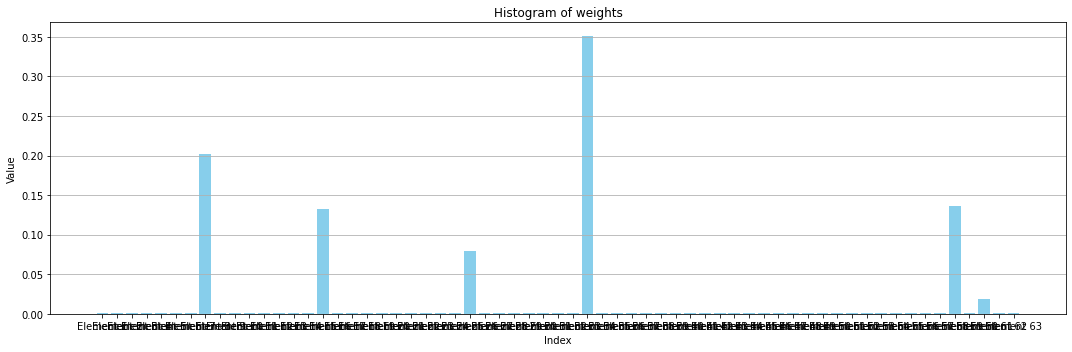

In [770]:
# Plotting the metrics
plt.figure(figsize=(20, 5))

# Loss Function Values
plt.subplot(1, 3, 1)
plt.plot(loss_values_ls)
plt.title('Objective Function Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Norm Gradient Values
plt.subplot(1, 3, 2)
plt.plot(grad_values_ls)
plt.title('Norm Gradient Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 3, 3)
plt.plot(returns_iteration_ls, label='Frank-Wolfe')
plt.title('Return over Iteration')
plt.xlabel('Iteration')
plt.ylabel('Return Mean')
plt.legend()

ret_mean_ls = checkMeanRet(optimal_weights_ls, mean_returns) * 100
risk_ls = portfolio_risk(optimal_weights_ls, cov_matrix)

print('\n' + PORTFOLIO)
print("Final weights:", optimal_weights_ls[:4])
print("Sum of weights:", np.sum(optimal_weights_ls))
print('Weekly Return Portfolio: ', ret_mean_ls, "%")
print('Yearly Return Portfolio: ', calculate_annual_return(ret_mean_ls), "%")
print('Max ret mean: ', np.max(mean_returns))
print("Risk: ", np.round(risk_ls,3), "%")

# Plotting the histogram
plt.figure(figsize=(15, 5))
plt.bar(range(len(optimal_weights_ls)), optimal_weights_ls, color='skyblue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Histogram of weights')
plt.xticks(range(len(optimal_weights_ls)), labels=[f'Element {i+1}' for i in range(len(optimal_weights_ls))])
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

### PairWise Frank Wolfe

In [771]:
ITERATIONS = 20

loss_values_pw = []
grad_values_pw = []
returns_iteration_pw = []

weights = np.ones(nStocks) / nStocks

for itr in range(ITERATIONS):
    if itr % (ITERATIONS * 0.05) == 0:
        print(f"{int(itr/ITERATIONS*100):02}%", end="")

    grad = gradient(weights, mean_returns, cov_matrix, RISK_AVERSION)
    
    # Trova gli indici con il gradiente minimo e massimo
    i = np.argmin(grad)
    j = np.argmax(grad)

    # Store values for plotting
    loss_values_pw.append(loss(weights, mean_returns, cov_matrix, RISK_AVERSION))
    grad_values_pw.append(np.linalg.norm(grad))
    returns_iteration_pw.append(checkMeanRet(weights, mean_returns))
    
    direction = np.zeros_like(weights)
    direction[i] = 1
    direction[j] = -1

    gamma = line_search(weights, direction, mean_returns, cov_matrix, RISK_AVERSION)

    weights += gamma * direction

    weights = np.clip(weights, 0, 1)
    weights /= np.sum(weights)
    
    if np.linalg.norm(grad) < 1e-6:
        break

    if itr % (ITERATIONS * 0.05) == 0:
        print(f" - ret {(returns_iteration_pw[-1])*100:05.2f}% - loss {loss(weights, mean_returns, cov_matrix, RISK_AVERSION):05.6f}")


# Esegui l'ottimizzazione con Pairwise Frank-Wolfe
optimal_weights_pw = weights

# Crea l'istogramma dei pesi
print('\n' + PORTFOLIO)
print(f"Sec Max Weights: {second_largest_partition(optimal_weights_pw)}")
print(f"Max Weights: {np.max(optimal_weights_pw)}")
print("Sum weights: ", np.sum(optimal_weights_pw))

00% - ret 00.23% - loss 0.001096
05% - ret 00.27% - loss 0.000298
10% - ret 00.31% - loss -0.000192
15% - ret 00.32% - loss -0.000529
20% - ret 00.36% - loss -0.000810
25% - ret 00.36% - loss -0.001007
30% - ret 00.37% - loss -0.001173
35% - ret 00.38% - loss -0.001242
40% - ret 00.38% - loss -0.001354
45% - ret 00.39% - loss -0.001442
50% - ret 00.41% - loss -0.001513
55% - ret 00.41% - loss -0.001453
60% - ret 00.40% - loss -0.001547
65% - ret 00.40% - loss -0.001631
70% - ret 00.41% - loss -0.001637
75% - ret 00.40% - loss -0.001606
80% - ret 00.40% - loss -0.001658
85% - ret 00.40% - loss -0.001551
90% - ret 00.42% - loss -0.001619
95% - ret 00.43% - loss -0.001706

Ftse100
Sec Max Weights: 0.1731787505400493
Max Weights: 0.3433386745397603
Sum weights:  1.0000000000000002



Ftse100
Final weights: [0.00132504 0.00132504 0.00132504 0.00132504]
Sum of weights: 1.0000000000000002
Weekly Return Portfolio:  0.4299942331330578 %
Yearly Return Portfolio:  24.996762097752434 %
Max ret mean:  0.006432427743566206
Risk:  0.016 %


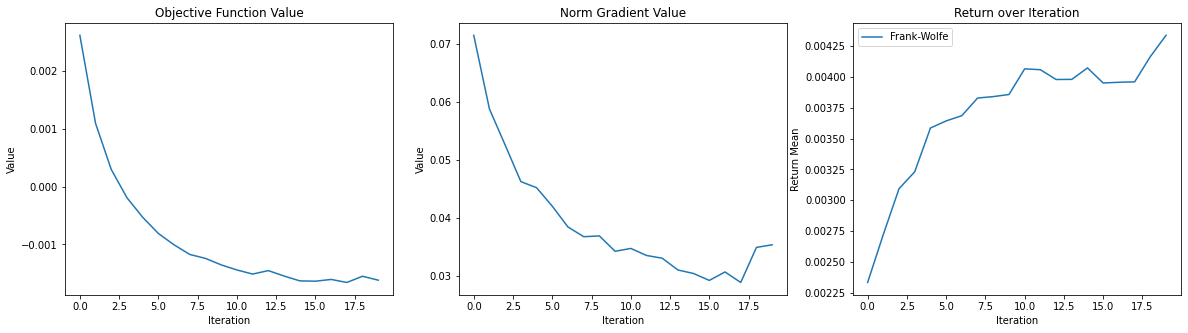

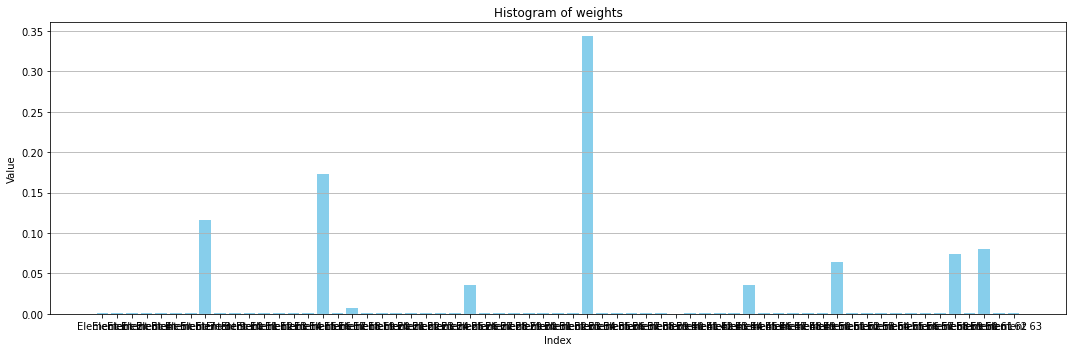

In [772]:
# Plotting the metrics
plt.figure(figsize=(20, 5))

# Loss Function Values
plt.subplot(1, 3, 1)
plt.plot(loss_values_pw)
plt.title('Objective Function Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Norm Gradient Values
plt.subplot(1, 3, 2)
plt.plot(grad_values_pw)
plt.title('Norm Gradient Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 3, 3)
plt.plot(returns_iteration_pw, label='Frank-Wolfe')
plt.title('Return over Iteration')
plt.xlabel('Iteration')
plt.ylabel('Return Mean')
plt.legend()

ret_mean_pw = checkMeanRet(optimal_weights_pw, mean_returns) * 100
risk_pw = portfolio_risk(optimal_weights_pw, cov_matrix)

print('\n' + PORTFOLIO)
print("Final weights:", optimal_weights_pw[:4])
print("Sum of weights:", np.sum(optimal_weights_pw))
print('Weekly Return Portfolio: ', ret_mean_pw, "%")
print('Yearly Return Portfolio: ', calculate_annual_return(ret_mean_pw), "%")
print('Max ret mean: ', np.max(mean_returns))
print("Risk: ", np.round(risk_pw,3), "%")

# Plotting the histogram
plt.figure(figsize=(15, 5))
plt.bar(range(len(optimal_weights_pw)), optimal_weights_pw, color='skyblue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Histogram of weights')
plt.xticks(range(len(optimal_weights_pw)), labels=[f'Element {i+1}' for i in range(len(optimal_weights_pw))])
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

### Away Step Frank Wolfe

In [773]:
%%time

ITERATIONS = 20

loss_values_aw = []
grad_values_aw = []
returns_iteration_aw = []

weights = np.ones(nStocks) / nStocks
V = [weights.copy()]  # Memorizza i vertici visitati

for itr in range(ITERATIONS):
    if itr % (ITERATIONS * 0.05) == 0:
        print(f"{int(itr/ITERATIONS*100):02}%", end="")

    grad = gradient(weights, mean_returns, cov_matrix, RISK_AVERSION)
    
    # Direzione Frank-Wolfe
    s = linear_solver(grad)
    d_fw = s - weights
    
    # Direzione di allontanamento
    j = np.argmax(np.dot(V, grad))
    v_j = V[j]
    d_away = weights - v_j
    
    # Determina la direzione e il passo ottimali
    if np.dot(grad, d_fw) < np.dot(grad, d_away):
        direction = d_fw
        step_size = 1.0  # Frank-Wolfe step
    else:
        direction = -d_away
        max_step_size = np.min(weights[weights > 0] / (weights[weights > 0] - v_j[weights > 0]))
        step_size = min(1.0, max_step_size)  # Away step

    # Store values for plotting
    loss_values_aw.append(loss(weights, mean_returns, cov_matrix, RISK_AVERSION))
    grad_values_aw.append(np.linalg.norm(grad))
    returns_iteration_aw.append(checkMeanRet(weights, mean_returns))

    gamma = line_search(weights, direction, mean_returns, cov_matrix, RISK_AVERSION)
    gamma = min(gamma, step_size)

    weights += gamma * direction
    weights = np.clip(weights, 0, 1)
    weights /= np.sum(weights)
    
    # Aggiungi nuovo vertice
    if np.array_equal(direction, d_fw):
        V.append(s.copy())
    else:
        if step_size == max_step_size and len(V) > 1:
            V.pop(j)  # Rimuovi vertice

    if np.linalg.norm(grad) < 1e-6:
        break

    if itr % (ITERATIONS * 0.05) == 0:
        print(f" - ret {(returns_iteration_aw[-1])*100:05.2f}% - loss {loss(weights, mean_returns, cov_matrix, RISK_AVERSION):05.6f}")
            

# Esegui l'ottimizzazione con Away-step Frank-Wolfe
optimal_weights_aw = weights

# Crea l'istogramma dei pesi
print('\n' + PORTFOLIO)
print(f"Sec Max Weights: {second_largest_partition(optimal_weights_aw)}")
print(f"Max Weights: {np.max(optimal_weights_aw)}")
print("Sum weights: ", np.sum(optimal_weights_aw))

00% - ret 00.23% - loss 0.000078
05% - ret 00.31% - loss -0.000815
10% - ret 00.37% - loss -0.001125
15% - ret 00.42% - loss -0.001628
20% - ret 00.49% - loss -0.001688
25% - ret 00.50% - loss -0.001849
30% - ret 00.48% - loss -0.001849
35% - ret 00.48% - loss -0.001849
40% - ret 00.48% - loss -0.001849
45% - ret 00.48% - loss -0.001849
50% - ret 00.48% - loss -0.001849
55% - ret 00.48% - loss -0.001849
60% - ret 00.48% - loss -0.001849
65% - ret 00.48% - loss -0.001849
70% - ret 00.48% - loss -0.001849
75% - ret 00.48% - loss -0.001849
80% - ret 00.48% - loss -0.001849
85% - ret 00.48% - loss -0.001849
90% - ret 00.48% - loss -0.001849
95% - ret 00.48% - loss -0.001849

Ftse100
Sec Max Weights: 0.2721820633147323
Max Weights: 0.2848289066606694
Sum weights:  1.0
CPU times: user 23.1 ms, sys: 9.52 ms, total: 32.6 ms
Wall time: 31.2 ms



Ftse100
Final weights: [0. 0. 0. 0.]
Sum of weights: 1.0
Weekly Return Portfolio:  0.4806413199681657 %
Yearly Return Portfolio:  28.31715186139503 %
Max ret mean:  0.006432427743566206
Risk:  0.017 %


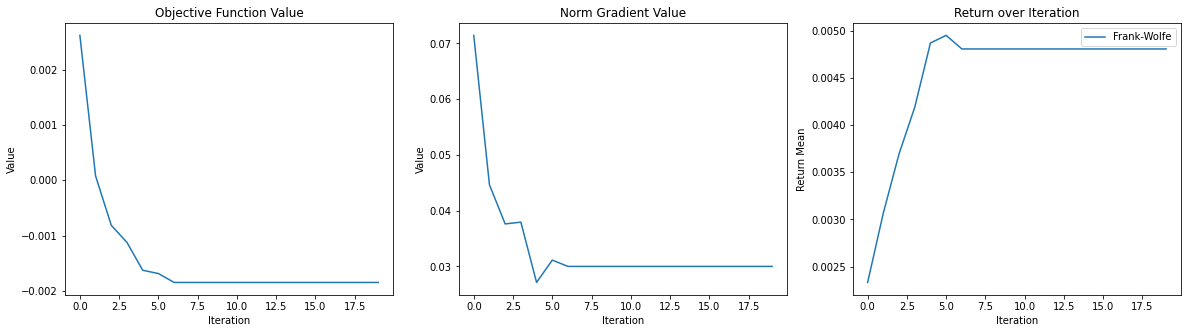

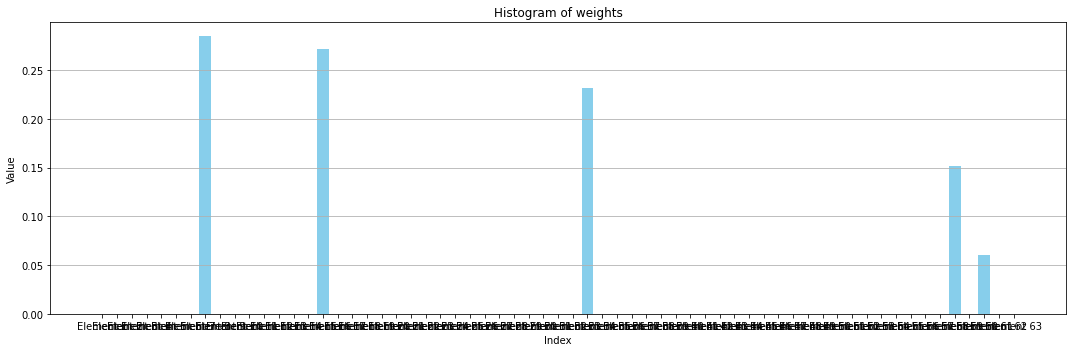

In [774]:
# Plotting the metrics
plt.figure(figsize=(20, 5))

# Loss Function Values
plt.subplot(1, 3, 1)
plt.plot(loss_values_aw)
plt.title('Objective Function Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Norm Gradient Values
plt.subplot(1, 3, 2)
plt.plot(grad_values_aw)
plt.title('Norm Gradient Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 3, 3)
plt.plot(returns_iteration_aw, label='Frank-Wolfe')
plt.title('Return over Iteration')
plt.xlabel('Iteration')
plt.ylabel('Return Mean')
plt.legend()

ret_mean_aw = checkMeanRet(optimal_weights_aw, mean_returns) * 100
risk_aw = portfolio_risk(optimal_weights_aw, cov_matrix)

print('\n' + PORTFOLIO)
print("Final weights:", optimal_weights_aw[:4])
print("Sum of weights:", np.sum(optimal_weights_aw))
print('Weekly Return Portfolio: ', ret_mean_aw, "%")
print('Yearly Return Portfolio: ', calculate_annual_return(ret_mean_aw), "%")
print('Max ret mean: ', np.max(mean_returns))
print("Risk: ", np.round(risk_aw,3), "%")

# Plotting the histogram
plt.figure(figsize=(15, 5))
plt.bar(range(len(optimal_weights_aw)), optimal_weights_aw, color='skyblue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Histogram of weights')
plt.xticks(range(len(optimal_weights_aw)), labels=[f'Element {i+1}' for i in range(len(optimal_weights_aw))])
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

In [775]:
# Example usage of the function
initial_amount = 10000  # Dollars
years = 5  # Years

final_amount, roi = calculate_gain(initial_amount, years, ret_mean_fw)
print(f"Investing {initial_amount}$ in the {PORTFOLIO} index for a total of {years} years.\n")
print(f"Final amount after {years} years: {round(final_amount)}$")
print(f"ROI: {roi:.2f} %")

Investing 10000$ in the Ftse100 index for a total of 5 years.

Final amount after 5 years: 31260$
ROI: 212.60 %



Ottimizzazione con scipy.optimize.minimize
Rendimento Atteso: 0.4458324208299001%
Perdita Ottimale: -0.0020451358374526077
Somma dei Pesi: 1.0000000000000002
Risk:  0.016 %
63


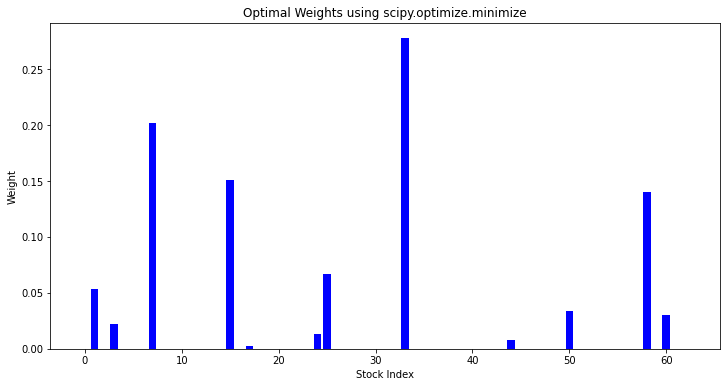

In [776]:
# Vincolo: la somma dei pesi deve essere 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Vincoli: i pesi devono essere tra 0 e 1
bounds = [(0, 1) for _ in range(nStocks)]

# Pesi iniziali
initial_weights = np.ones(nStocks) / nStocks

# Ottimizzazione con scipy.optimize.minimize
result = minimize(loss, initial_weights, args=(mean_returns, cov_matrix, RISK_AVERSION), method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights_scipy = result.x

# Stampa dei risultati
print('\nOttimizzazione con scipy.optimize.minimize')
print(f"Rendimento Atteso: {checkMeanRet(optimal_weights_scipy, mean_returns)*100}%")
print(f"Perdita Ottimale: {loss(optimal_weights_scipy, mean_returns, cov_matrix, RISK_AVERSION)}")
print(f"Somma dei Pesi: {np.sum(optimal_weights_scipy)}")

risk = portfolio_risk(optimal_weights_scipy, cov_matrix)
print("Risk: ", np.round(risk,3), "%")

print(nStocks)
# Plot dell'istogramma dei pesi ottimali
plt.figure(figsize=(12, 6))
plt.bar(range(nStocks), optimal_weights_scipy, color='blue')
plt.xlabel('Stock Index')
plt.ylabel('Weight')
plt.title('Optimal Weights using scipy.optimize.minimize')
plt.show()

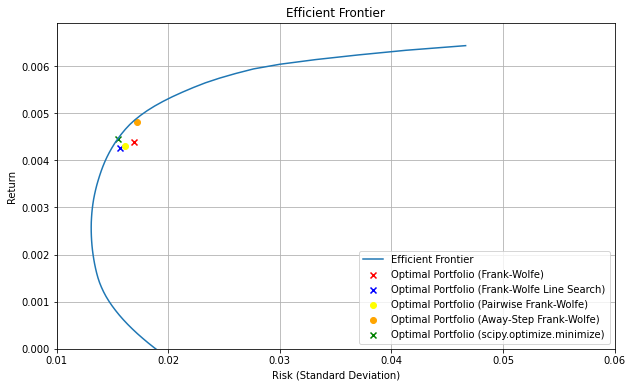

In [777]:
optimal_risk_fw = portfolio_risk(optimal_weights_fw, cov_matrix)
optimal_return_fw = portfolio_return(optimal_weights_fw, mean_returns)

optimal_risk_scipy = portfolio_risk(optimal_weights_scipy, cov_matrix)
optimal_return_scipy = portfolio_return(optimal_weights_scipy, mean_returns)

optimal_risk_linesearch = portfolio_risk(optimal_weights_ls, cov_matrix)
optimal_return_linesearch = portfolio_return(optimal_weights_ls, mean_returns)

optimal_risk_pw = portfolio_risk(optimal_weights_pw, cov_matrix)
optimal_return_pw = portfolio_return(optimal_weights_pw, mean_returns)

optimal_risk_aw = portfolio_risk(optimal_weights_aw, cov_matrix)
optimal_return_aw = portfolio_return(optimal_weights_aw, mean_returns)

# Genera la frontiera efficiente
target_returns = np.linspace(min(mean_returns), max(mean_returns), 100)
efficient_portfolios = []

for target_return in target_returns:
    efficient_portfolios.append(minimize_risk(len(mean_returns) * [1. / len(mean_returns)], mean_returns, cov_matrix, target_return))

# Estrai i rischi e i rendimenti dei portafogli efficienti
risks = [portfolio_risk(x['x'], cov_matrix) for x in efficient_portfolios]
returns = [portfolio_return(x['x'], mean_returns) for x in efficient_portfolios]

# Visualizza la frontiera efficiente
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, label='Efficient Frontier')
plt.scatter(optimal_risk_fw, optimal_return_fw, color='red', label='Optimal Portfolio (Frank-Wolfe)', marker='x')
plt.scatter(optimal_risk_linesearch, optimal_return_linesearch, color='blue', label='Optimal Portfolio (Frank-Wolfe Line Search)', marker='x')
plt.scatter(optimal_risk_pw, optimal_return_pw, color='yellow', label='Optimal Portfolio (Pairwise Frank-Wolfe)', marker='o')
plt.scatter(optimal_risk_aw, optimal_return_aw, color='orange', label='Optimal Portfolio (Away-Step Frank-Wolfe)', marker='o')
plt.scatter(optimal_risk_scipy, optimal_return_scipy, color='green', label='Optimal Portfolio (scipy.optimize.minimize)', marker='x')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.ylim(0) 
plt.xlim(0.01,0.06) 
plt.legend()
plt.grid(True)
plt.show()

In [778]:
# Converti i rendimenti settimanali in rendimenti annuali (approssimando 52 settimane in un anno)
def annualize_return(weekly_return):
    return (1 + weekly_return) ** 52 - 1

# Calcola i rendimenti annuali
annual_return_fw = annualize_return(optimal_return_fw)
annual_return_scipy = annualize_return(optimal_return_scipy)
annual_return_linesearch = annualize_return(optimal_return_linesearch)
annual_return_pw = annualize_return(optimal_return_pw)
annual_return_aw = annualize_return(optimal_return_aw)

# Arrotonda i dati e convertili in percentuale
data = {
    'Method': ['Frank-Wolfe', 'SciPy Optimization', 'Line Search Frank-Wolfe', 'Pairwise Frank-Wolfe', 'Away-step Frank-Wolfe'],
    'Optimal Risk (%)': [round(optimal_risk_fw * 100, 2), round(optimal_risk_scipy * 100, 2), round(optimal_risk_linesearch * 100, 2), round(optimal_risk_pw * 100, 2), round(optimal_risk_aw * 100, 2)],
    'Weekly Return (%)': [round(optimal_return_fw * 100, 2), round(optimal_return_scipy * 100, 2), round(optimal_return_linesearch * 100, 2), round(optimal_return_pw * 100, 2), round(optimal_return_aw * 100, 2)],
    'Annual Return (%)': [round(annual_return_fw * 100, 2), round(annual_return_scipy * 100, 2), round(annual_return_linesearch * 100, 2), round(annual_return_pw * 100, 2), round(annual_return_aw * 100, 2)]
}

results_df = pd.DataFrame(data)
print(tabulate(results_df, headers='keys', tablefmt='pretty'))

+---+-------------------------+------------------+-------------------+-------------------+
|   |         Method          | Optimal Risk (%) | Weekly Return (%) | Annual Return (%) |
+---+-------------------------+------------------+-------------------+-------------------+
| 0 |       Frank-Wolfe       |       1.69       |       0.44        |       25.6        |
| 1 |   SciPy Optimization    |       1.55       |       0.45        |       26.03       |
| 2 | Line Search Frank-Wolfe |       1.57       |       0.43        |       24.74       |
| 3 |  Pairwise Frank-Wolfe   |       1.61       |       0.43        |       25.0        |
| 4 |  Away-step Frank-Wolfe  |       1.72       |       0.48        |       28.32       |
+---+-------------------------+------------------+-------------------+-------------------+


Index: Ftse100
Risk Aversion: 10


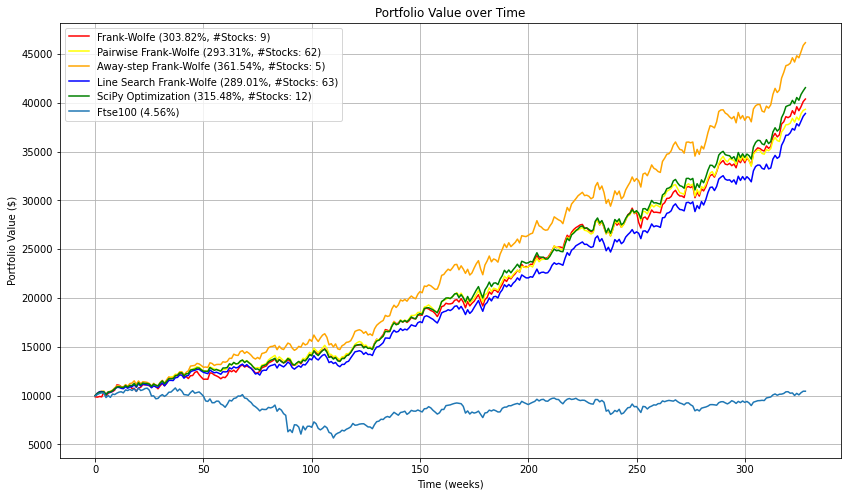

In [779]:
print(f"Index: {PORTFOLIO}")
print(f"Risk Aversion: {RISK_AVERSION}")

initial_investment = 10000

# Calcola il valore del portafoglio nel tempo
def portfolio_value(weights, matrix_ret, initial_investment):
    cumulative_returns = np.cumprod(1 + np.dot(matrix_ret, weights))
    return initial_investment * cumulative_returns

def calculate_investment_value(array_ret, initial_investment):
    # Convertiamo i ritorni percentuali in fattori moltiplicativi
    factors = 1 + np.array(array_ret)
    
    # Calcoliamo il valore cumulativo dell'investimento
    cumulative_returns = np.cumprod(factors)
    
    # Moltiplichiamo per l'investimento iniziale
    investment_value = initial_investment * cumulative_returns
    
    return investment_value

# Calcolo del numero di pesi maggiori di zero
def num_positive_weights(weights):
    return np.sum(weights > 0.0009)

# Calcola i valori del portafoglio per ciascun metodo
portfolio_values_fw = portfolio_value(optimal_weights_fw, matrix_rr, initial_investment)
portfolio_values_pw = portfolio_value(optimal_weights_pw, matrix_rr, initial_investment)
portfolio_values_aw = portfolio_value(optimal_weights_aw, matrix_rr, initial_investment)
portfolio_values_ls = portfolio_value(optimal_weights_ls, matrix_rr, initial_investment)
portfolio_values_scipy = portfolio_value(optimal_weights_scipy, matrix_rr, initial_investment)
portfolio_values_index = calculate_investment_value(array_ret, initial_investment)

# Calcola i ritorni percentuali finali
final_return_fw = (portfolio_values_fw[-1] / initial_investment - 1) * 100
final_return_pw = (portfolio_values_pw[-1] / initial_investment - 1) * 100
final_return_aw = (portfolio_values_aw[-1] / initial_investment - 1) * 100
final_return_ls = (portfolio_values_ls[-1] / initial_investment - 1) * 100
final_return_scipy = (portfolio_values_scipy[-1] / initial_investment - 1) * 100
final_return_index = (portfolio_values_index[-1] / initial_investment - 1) * 100

# Calcola il numero di pesi maggiori di zero per ciascun metodo
num_positive_fw = num_positive_weights(optimal_weights_fw)
num_positive_pw = num_positive_weights(optimal_weights_pw)
num_positive_aw = num_positive_weights(optimal_weights_aw)
num_positive_ls = num_positive_weights(optimal_weights_ls)
num_positive_scipy = num_positive_weights(optimal_weights_scipy)

# Plot dei valori del portafoglio nel tempo
plt.figure(figsize=(14, 8))
plt.plot(portfolio_values_fw, label=f'Frank-Wolfe ({final_return_fw:.2f}%, #Stocks: {num_positive_fw})', color='red')
plt.plot(portfolio_values_pw, label=f'Pairwise Frank-Wolfe ({final_return_pw:.2f}%, #Stocks: {num_positive_pw})', color='yellow')
plt.plot(portfolio_values_aw, label=f'Away-step Frank-Wolfe ({final_return_aw:.2f}%, #Stocks: {num_positive_aw})', color='orange')
plt.plot(portfolio_values_ls, label=f'Line Search Frank-Wolfe ({final_return_ls:.2f}%, #Stocks: {num_positive_ls})', color='blue')
plt.plot(portfolio_values_scipy, label=f'SciPy Optimization ({final_return_scipy:.2f}%, #Stocks: {num_positive_scipy})', color='green')
plt.plot(portfolio_values_index, label=f'{PORTFOLIO} ({final_return_index:.2f}%)')
plt.xlabel('Time (weeks)')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value over Time')
plt.legend()
plt.grid(True)
plt.show()